In [1]:
%%javascript 
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Variational inference for a simple one parameter linear model

### Basics

VI (see [Blei et al 2018](https://arxiv.org/abs/1601.00670)) is a way of turning the approximation of a posterior distribution, $p(\theta | D)$, from a sampling problem (ie using MCMC) into an optimization problem. The advantage of doing this is that we can build an approximate distribution more quickly via optimization. The disadvantage is often a poorer approximation in many cases (specifically, we have to choose the form of the approximation and so misspecification at this stage cannot be overcome even asymptotically, unlike most sampling methods). 

VI aims to find the distribution closest to the posterior according to the Kullback-Leibler divergence
$$q^*(\theta) = \arg \min_q KL(q(\theta) || p(\theta | D))$$
We usually restrict $q$ to lie in some parametric family of distributions, ie, $q=q_\phi$, and then find
$$\phi^* = \arg \min_\phi KL(q_\phi(\theta) || p(\theta | D))$$

We can't compute this directly, but by noting that

\begin{align*}
KL(q_\phi(\theta) || p(\theta | D)) &= \mathbb{E}_{\theta \sim q} (\log q(\theta) - \log p(\theta | D))\\
&= \mathbb{E}_{\theta \sim q} \log q(\theta) - \mathbb{E}_{\theta \sim q} \log p(\theta, D) + \log p(D)
\end{align*}

we can see that minimizing the KL is equivalent to maximizing 
\begin{equation}
\mathcal{L}(\phi) = \mathbb{E} \log p(\theta, D) - \mathbb{E} \log q_\phi(\theta)
\end{equation}
where all expectations are with respect to $\theta \sim q_\phi(\theta)$. $\mathcal{L}$ is called the evidence lower bound (ELBO). 


An equivalent expression that will be useful is 
\begin{equation}
\mathcal{L} = \mathbb{E} \log p(D|\theta) - KL(q(\theta)|| p(\theta))
\end{equation}
ie, the ELBO is a trade-off between minimizing the expected log-likelihood of the data under $q$ whilst not moving too far from the prior distribution $p(\theta)$. It is a balance between fitting the data, and taking account of the prior.

### Simple linear model
Consider the simple linear model
$$y_i = ax_i + N(0,1) \qquad a \sim N(0, 100)$$
The posterior can be computed exactly in this case and is
$$a \sim N\left( \frac{\sum x_i y_i}{\frac{1}{100}+ \sum x_i^2}, (\frac{1}{100} +\sum x_i^2)^{-1}\right)$$
(which as a sanity check, tends to the OLS estimator as the number of data points grows, or as the prior variance grows).


We'll now consider variational inference for this model. We will use  Gaussian  distributions as the variational family 
$$q_\phi(a) = N(\mu, \sigma^2)$$
We thus have two variational parameters to learn $\phi=(\mu, \log \sigma^2)$. We use $\log \sigma^2$ to avoid problems with negative variances. Note that the variational family is of the correct parametric form, so that VI should give us the exact posterior distribution in this case (ie $q^* = p(\theta|D)$ if we do everything correctly).

We want to choose $\phi$ to maximize the ELBO
$$\mathcal{L}(\phi) = \mathbb{E}_{a\sim q_\phi} \log p(y|x,a)- KL(q_\phi(a)||p(a))$$
For this model, we have
$$\log p(y|x,a) \propto -\frac{1}{2} \sum (y_i -ax_i)^2 = -\frac{1}{2} \sum(y_i -\mu x_i +\mu x_i -ax_i)^2$$
where we've ignored terms that don't depend on the variational parameters (as they won't matter when we maximize). Taking the expectation wrt q we get 
$$\mathbb{E}_{a\sim q} \log p(y|x,a) = -\frac{1}{2} \sum ((y_i-\mu x_i)^2 +x_i^2 \sigma^2)$$

For two Gaussian distributions it is easy to show
$$KL(N(\mu_1, \sigma^2_1)|| N(\mu_2, \sigma^2_2)) = -\frac{1}{2}\log \frac{\sigma_1^2}{\sigma_2^2}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$
which completes the calculation of  the ELBO:

$$\mathcal{L}(\phi) \propto -\frac{1}{2} \sum (y_i-\mu x_i)^2 -\frac{\sigma^2}{2} \sum x_i^2 + \frac{1}{2}\log \sigma^2 - \frac{\sigma^2+\mu^2}{200}$$

If we differentiate wrt $\mu$ and $\sigma^2$, set the derivatives to zero, and solve, we find 
$$\sigma^2 =  (\frac{1}{100} +\sum x_i^2)^{-1} \qquad \mu = \frac{\sum x_i y_i}{\frac{1}{100}+ \sum x_i^2}$$
As expected, we find that $q^* = p(\theta | D)$, ie VI is exact in this special case.

## VI in practice
This calculation required three steps that may be difficult for more realistic models.

1. Computation of $\mathbb{E}_{\theta \sim q_\phi(\theta)} \log p(D|\theta )$
2. Computation of $KL(q_\phi(\theta)||p(\theta))$
3. Optimization of the ELBO wrt variational parameters $\phi$.

Problem 2 doesn't occur as often as 1 and 3, as the prior distribution and variational family are  usually  choosen to be simple forms allowing us to compute the KL divergence analytically.

### Using jax to optimize

Let's first assume that we can compute the ELBO analytically, and that the optimization (problem 3) is hard. We can use an autodiff language such as jax to help with the optimization of the ELBO. Here I'll use [jax](https://github.com/google/jax). Jax does a number of cool things in addition to autodiff, including just in time compilation which we'll make use of to speed up the code.
 

In [4]:
!pip install --upgrade pip
!pip install --upgrade jax jaxlib 

    100% |████████████████████████████████| 1.4MB 1.2MB/s ta 0:00:01
  Found existing installation: pip 19.0.3
    Uninstalling pip-19.0.3:
      Successfully uninstalled pip-19.0.3
     |████████████████████████████████| 270 kB 180 kB/s eta 0:00:01
     |████████████████████████████████| 37.1 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.3 MB/s eta 0:00:011
  Created wheel for jax: filename=jax-0.1.59-py3-none-any.whl size=314118 sha256=198e9af82a54fe52182b009298f26669075a863f7a079a6f9550735a24e536ce
  Stored in directory: /Users/ines_admin/Library/Caches/pip/wheels/11/2c/6f/fc95a3c91e43f4bd1646013812a25bd60773e222c2f1b91026
  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=121930 sha256=51ea4efc29749530bdfaaa4d549e494c8fa552173f70b84da6cd7efa82809a41
  Stored in directory: /Users/ines_admin/Library/Caches/pip/wheels/cc/af/1a/498a24d0730ef484019e007bb9e8cef3ac00311a67

In [2]:
import jax.numpy as np
from jax import grad, jit

In [3]:
def KL(mu, sigma2):
    return(-0.5* np.log(sigma2)+(sigma2+mu**2)/200.)

@jit
def Eloglike(mu, sigma2):
    return(-0.5*np.sum((y-mu*x)**2)-0.5*sigma2*np.sum(x**2))

@jit
def objective(phi):
    #phi = mu, log(sigma2)
    mu = phi[0]
    sigma2=np.exp(phi[1])
    ELBO = Eloglike(mu, sigma2)-KL(mu, sigma2)
    return(ELBO)

Let's create some data to use, and compute the true posterior distribution.

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import norm # should I use jax random numbers?
n=20 # number of observations
x = norm.rvs(size=n)
x

array([ 0.95479553, -1.86934204,  0.68653766,  0.00325757,  0.31127602,
       -0.9824148 , -0.15859628, -0.55946781,  0.1141355 ,  0.17016842,
        1.4563697 ,  1.57701371,  1.13507447, -0.26317518,  1.13497548,
       -0.19678488, -0.18221652,  0.18936489, -1.49220662,  0.25252455])

In [21]:
x = norm.rvs(size=n)
x

array([ 1.26806152,  1.79345345, -1.07681494, -1.41329861,  0.28610633,
        1.71312438,  0.34329721,  2.61799689,  0.40558533, -0.12088764,
        1.20354412,  0.31583308,  1.20684659,  1.54071297,  1.07880795,
        2.01063627, -0.37180074, -1.02278802, -1.48061677, -0.67956874])

ERROR : *2


True posterior is N( 1.9471145 , 0.015125508 )


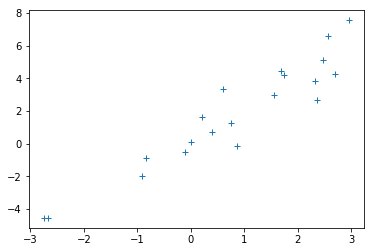

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import norm # should I use jax random numbers?
n=20 # number of observations
x = norm.rvs(size=n)*2
y= 2.*x + norm.rvs(size=n)
plt.plot(x,y, '+')

mu_posterior = np.sum(x*y)/(1./100+np.sum(x**2))
sigma2_posterior = 1./(1./100+np.sum(x**2))
phi_opt = np.array((mu_posterior, np.log(sigma2_posterior)))


print('True posterior is N(', mu_posterior, ',', sigma2_posterior,')')



Let's first optimize using scipy's built in optimization function. This doesn't use anything other than evaluations of the ELBO (ie it doesn't use derivative information).

nelder-mead ?

In [23]:
from scipy.optimize import minimize

def negElbo(phi):
    return(-1.* objective(phi))

phi0=np.array((1.,np.log(2.)))

res=minimize(negElbo, phi0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
print('Optimized values=',res.x[0], np.exp(res.x[1]))
print('True values', mu_posterior, sigma2_posterior)

Optimization terminated successfully.
         Current function value: 9.412601
         Iterations: 62
         Function evaluations: 157
Optimized values= 2.067446196195897 0.016868861
True values 1.9471145 0.015125508


In [13]:
negElbo(phi0)

DeviceArray(99.54626, dtype=float32)

Now let's use Newton Raphson to optimize instead, using jax to compute the gradient and Hessian matrix. 
$$\phi_{n+1} = \phi_n -H^{-1}(\phi_n)\nabla \mathcal{L}(\phi_n)$$ and iterate until the ELBO ceases to change.

In [9]:
phi0=np.array((1.,np.log(2.))) # pick a start point
dphi =jit(grad(objective))# use jit  to compile and speed up code. Can be removed. 
dphi(phi_opt) # derivatves should be zero at the optimal values


DeviceArray([-1.0784715e-06,  0.0000000e+00], dtype=float32)

In [10]:
from jax import jacfwd, jacrev
def hessian(f):
    return jacfwd(jacrev(f))

H=jit(hessian(objective)) #jit gives an approximate x~300 speed up!
H(phi_opt)




DeviceArray([[-24.376001  ,   0.        ],
             [  0.        ,  -0.50000006]], dtype=float32)

In [11]:
from jax import value_and_grad
obj_dphi = jit(value_and_grad(objective))

@jit
def NewtonRaphsonStep(phi):
    obj,gra = obj_dphi(phi)
    print(gra)
    phinew = phi - np.linalg.inv(H(phi)) @ gra
    print(phinew)
    return(obj, phinew)


phi=phi0
obj=1000
dobj=1000
while dobj >10e-2:
    objnew, phinew=NewtonRaphsonStep(phi)
    phi=phinew
    dobj = np.abs(obj-objnew)
    obj=objnew
    print('objective=',obj, ', change in objective=', dobj)

mle_NR = phi
print('Optimized values=',mle_NR[0], np.exp(mle_NR[1]))
print('True values', mu_posterior, sigma2_posterior)

Traced<ShapedArray(float32[2]):JaxprTrace(level=-1/1)>
Traced<ShapedArray(float32[2]):JaxprTrace(level=-1/1)>
objective= -48.52886 , change in objective= 1048.5288
objective= -23.259357 , change in objective= 25.2695
objective= -18.135132 , change in objective= 5.1242256
objective= -16.514288 , change in objective= 1.6208439
objective= -16.11457 , change in objective= 0.39971733
objective= -16.06145 , change in objective= 0.053121567
Optimized values= 1.9297844 0.041158717
True values 1.9297844 0.04102396


### Using estimates of the expected log-likelihood

Let's now tackle problem 1. 

- Computation of $\mathbb{E}_{\phi \sim q} \log p(y|\theta )$.

Several approaches have been suggested. I'll look at two: [black-box VI](https://arxiv.org/abs/1401.0118) and the [variational autoencoder (VAE)](https://arxiv.org/abs/1312.6114).


#### VAE
We can approximate $\mathbb{E}_{\phi \sim q} \log p(y|\theta )$ by a Monte Carlo sum. For our worked example we have
$$\mathbb{E}_{a \sim q} \log p(y|x, a ) \approx \frac{1}{S} \sum_{s=1}^S \log p(y|x, a_s )$$
where $a_s \sim q_\phi(a)$.

However, we want to use autodiff to compute the gradient of $\mathcal{L}$ wrt $\phi$, but $\phi$ doesn't explicitly appear in this expression - only samples generated from $q_\phi$ are used (this is often phrased as saying we  
can't autodiff through random samples). However, by using the 'reparameterization trick', we can write $a_s = \mu+\sigma e_i$, and then write 
$$\mathbb{E}_{a \sim q} \log p(y|x, a )=\mathbb{E}_{e \sim N(0,1)} \log p(y|x, a=\mu+\sigma e ) \approx \frac{1}{S} \sum_{s=1}^S \log p(y|x, a=\mu+\sigma e_s )$$
This is now a function of the variational parameters $\phi=(\mu, \log \sigma^2)$, and we can use auto-diff to compute the derivatives. This is essentially the variational autoencoder (VAE) of Kingma and Welling.



In [12]:
from jax import vmap, random
key = random.PRNGKey(1)

@jit
def loglike(mu, sigma, e):
    # NOTE - takes sigma not sigma2 as input
    return(-0.5*np.sum((y-(mu+sigma*e)*x)**2))  

def stochastic_objective(phi,  key, S=50):
    #phi = mu, log(sigma2)
    # S = number of MC samples
    mu = phi[0]
    sigma=np.exp(phi[1]/2.) # sigma2 = e^phi[1] so sigma = sqrt(e^phi[1])
    esamples = random.normal(key, shape=(S,1))
    #Eloglike= np.mean(np.array([loglike(mu,sigma, e) for e in esamples]))# - using vmap is much faster ~100x
    Eloglike = np.mean(vmap(loglike, in_axes=(None, None,0))(mu, sigma, esamples))
 
    ELBO = Eloglike-KL(mu, sigma**2)
    return(ELBO)


In [13]:
key, subkey = random.split(key)
stochH=hessian(stochastic_objective)
#print(stochH(phi_opt, S=100000))

stochobj_dphi = value_and_grad(stochastic_objective)
stochobj_dphi(phi_opt, subkey, S=10000)

#dphi(phi_opt) # gradient should be ~0 at optima.

(DeviceArray(-16.065996, dtype=float32),
 DeviceArray([-0.04633919, -0.00629849], dtype=float32))

In [14]:

obj=1000
dobj=1000
phi = np.array((1.,1.))
S=500
while dobj >10e-3:
    key, *subkeys = random.split(key, 3)
    obj_new, gra = stochobj_dphi(phi, subkeys[0], S)
    phinew = phi - np.linalg.inv(stochH(phi, subkeys[1], S)) @ gra
    phi=phinew
    dobj = np.abs(obj-obj_new)
    obj=obj_new
    print('objective=',obj, ', change in objective=', dobj)
    print('--------')
    
print('Optimized values=',phi[0], np.exp(phi[1]))
print('True values', mu_posterior, sigma2_posterior)

objective= -60.205963 , change in objective= 1060.2059
--------
objective= -24.595968 , change in objective= 35.609993
--------
objective= -18.196777 , change in objective= 6.399191
--------
objective= -16.572546 , change in objective= 1.6242313
--------
objective= -16.102705 , change in objective= 0.469841
--------
objective= -16.081274 , change in objective= 0.02143097
--------
objective= -16.038221 , change in objective= 0.043052673
--------
objective= -16.045786 , change in objective= 0.0075645447
--------
Optimized values= 1.9364588 0.04252412
True values 1.9297844 0.04102396


I've still used Newton Raphson here, but given the objective is now stochastic, I suspect some care is need. I've used new random samples each time, which is probably the right thing to do. Fixing the random numbers makes convergence faster though (as the target doesn't change).
The stopping criterion is more difficult now, as it is sensitive to S, the number of Monte Carlo samples used. For small S, the objective will always fluctuate and so too small a stopping criterion shouldn't be used. Also, I imagine the Hessian might be quite sensitive to the stochastic  samples. I expect it could be beneficial to scale a learning rate (and S) like in the SGD, but don't know enough about this to be sure.


Testing, it seems to work reasonably even for $S=50$, but sometimes crashes for $S=10$.


## Black-box VI

Black box VI works differently. By noting that
$$ \nabla_\phi \log q_\phi(\theta) = \frac{\nabla_\phi q_\phi(\theta)}{q_\phi(\theta)}$$
so that $\nabla_\phi \mathbb{E}_{\theta\sim q_\phi} f(\theta) = \mathbb{E}[f(\theta)\nabla \log q_\phi(\theta)]$.  Applying this to equation (1) gives
$$\nabla_\phi \mathcal{L} = \mathbb{E}_{\theta \sim q_\phi}\left(\nabla \log q_\phi(\theta)(\log p(\theta, D) - \log q_\phi(\theta))\right)$$

For most choices of $q$, we will usually be able to compute $\nabla \log q_\phi(\theta)$, and then approximate this gradient by
$$\nabla_\phi \mathcal{L} \approx \frac{1}{S}\sum_{s=1}^S \nabla \log q_\phi(\theta_s)(\log p(\theta_s, D) - \log q_\phi(\theta_s))$$
where $\theta_s \sim q_\phi(\theta)$.

In the paper they then use a variety of variance reduction techniques before using stochastic gradient descent. I suspect the estimates are rather noisy compared to the VAE, but it would be interesting to compare. 

## Tidy VAE code

To make the code look more like standard VAE code we can write it in terms of a encoder and decoder.


In [15]:
class VAE():
    def __init__(self, x, y, S=50, phi0=np.array((1.,1.))):
        self.x = x
        self.y = y
        self.phi=phi0
        #self.mu = 1. # starting point - make random?
        #self.logvar = 1. # starting point - make random
        #self.var=np.exp(self.logvar) # is it daft storing all of these?
        #self.sd = np.exp(self.logvar/2.)
        self.S=S
        
    def encoder(self, phi):
        ## what should this do? not currently being used.
        '''Encoder using a gaussian distribution with parameters mu and logvar'''
        self.phi=phi
        self.mu = phi[0]
        self.logvar = phi[1]
        self.var=np.exp(self.logvar)
        self.sd=np.exp(self.logvar/2.)
        return(None)

    def reparam(self, e):
        '''Reparametrization trick - converts a random N(0,1) into theta'''
        return(self.mu + e*self.sd)

    def decoder(self, theta):
        ''' model prediction give theta'''
        return(theta*self.x) # model prediction is y=theta*x

    def loglike(self, theta):
        # NOTE - takes sigma not sigma2 as input
        return(-0.5*np.sum((self.y-self.decoder(theta))**2))  
      
    def loss(self, phi, key):
        self.encoder(phi)
        kld = -0.5* self.logvar+(np.exp(self.logvar) + self.mu**2)/200.
        esamples=random.normal(key, shape=(self.S,1))
        thetasamples = self.reparam(esamples)
        Eloglike = np.mean(vmap(self.loglike, in_axes=(0))(thetasamples))
        return(kld-Eloglike)
    
    

In [16]:
model = VAE(x, y,S=50)
dphi_vae = value_and_grad(model.loss)
H_vae = hessian(model.loss)

In [17]:
key, subkey = random.split(key)
print('----- check losses ------', )
print('vae loss', model.loss(phi, subkey))
print('true Eloglike',objective(phi))
print('----- check gradients ------', )
print(dphi_vae(phi_opt, subkey))
print(dphi(phi))
print('----- check Hessians ------', )
print(H_vae(phi, subkey))
print(H(phi))



----- check losses ------
vae loss 16.039413
true Eloglike -16.060589
----- check gradients ------
(DeviceArray(16.032167, dtype=float32), DeviceArray([ 1.0843958, -0.0271202], dtype=float32))
[-0.16269672 -0.01828397]
----- check Hessians ------
[[24.376       0.5520218 ]
 [ 0.55202186  0.49224073]]
[[-24.376001   0.      ]
 [  0.        -0.518284]]


In [18]:

phi=np.array((1.,1.))
model = VAE(x, y,S=500000, phi0=phi)

obj=1000
dobj=1000

while dobj >10e-2:
    key, *subkeys = random.split(key, 3)
    obj_new, gra = dphi_vae(phi, subkeys[0])
    phinew = phi - np.linalg.inv(H_vae(phi, subkeys[1])) @ gra
    phi=phinew
    model.encoder(phi)
    dobj = np.abs(obj-obj_new)
    obj=obj_new
    print('objective=',obj, ', change in objective=', dobj)
    print('--------')
    
print('Optimized values=',model.mu, model.var,)
print('True values', mu_posterior, sigma2_posterior)

objective= 49.419678 , change in objective= 950.5803
--------
objective= 31.636492 , change in objective= 17.783186
--------
objective= 19.108315 , change in objective= 12.528177
--------
objective= 16.495693 , change in objective= 2.6126213
--------
objective= 16.130854 , change in objective= 0.36483955
--------
objective= 16.07868 , change in objective= 0.052173615
--------
Optimized values= 1.9293631 0.041490264
True values 1.9297844 0.04102396


### Amortized inference

Can we learn $q(a|x,y)=N(\mu(x,y), \sigma^2(x,y))$ for any possible choice of $x$ and $y$?
We know the correct structural form for $\mu(x,y)$ and $\sigma^2(x,y)$. If we model them as neural networks, then given new data $x,y$ we would be able to quickly return the posterior. How do we train this model?

## READ VAE paper properly